In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from amb_scripts.load_saved_info import *
from amb_scripts.plot_csfv3 import *

from dag_prf_utils.prfpy_functions import *
from dag_prf_utils.plot_functions import *
from dag_prf_utils.utils import *
from dag_prf_utils.mesh_maker import *

plot_cols = get_plot_cols()

fs_dir = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/daghlian/.conda/envs/dag_mcmc/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
# fs_dir = opj(os.getenv('DIR_DATA_DERIV'), 'freesurfer')

fs = FSMaker('sub-02', fs_dir)
# roi_list = ['V1','V2','V3.','V3a', 'V3b','hV4','VO1','VO2','LO1','LO2','TO1','TO2']
fs.open_fs_surface(
    ['L-1-gauss-pol',
    # # 'R-2-csf-AULCSF', 
    # # 'R-1-csf-rsq',    
    # # 'R-2-csf-rsq', 
    ], 
    # roi_list=roi_list,
    overlay_cmap='', vmin=10,vmax=11, 
    )


ERROR: could not find volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/None.  Does it exist?
ERROR: could not find volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/None.  Does it exist?


error: mri_read(): couldn't determine type of file /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/None
could not read overlay data from /data1/projects/dumoulinlab/Lab_members/Marcus/projects/pilot1/derivatives/freesurfer/sub-02/surf/None


In [6]:
sub='sub-02'
ses='ses-1'
task = 'pRFLE'
model='gauss'

min_rsq = .1
max_ecc = 5

prf_data = amb_load_prf_params(
    sub=sub,
    task_list=task,
    model_list=model,
    ses=ses
)[task][model]
prf_obj = Prf1T1M(prf_data, model)
fs = FSMaker(sub, fs_dir)
fs.add_surface(
    data =prf_obj.pd_params['pol4roi'].to_numpy(),
    data_mask = prf_obj.return_vx_mask({'min-rsq':min_rsq, 'max-ecc':max_ecc}),
    cmap='pol_simple',
    vmin=0, vmax=180,
    cmap_nsteps=100,        
    surf_name='pol4roi',
)
fs.add_surface(
    data =prf_obj.pd_params['ecc'].to_numpy(),
    data_mask = prf_obj.return_vx_mask({'min-rsq':min_rsq, 'max-ecc':max_ecc}),
    cmap='ecc',
    vmin=0, vmax=max_ecc,
    cmap_nsteps=100,        
    surf_name='ecc4roi',
)
roi_list = ['V1','V2','V3','hV4', 'VO1','VO2','LO1','LO2', 'TO1','TO2','V3b','V3a']

# roi_list = ['V1','V2','V3.','V3a', 'V3b','hV4','VO1','VO2','LO1','LO2','TO1','TO2']
fs.open_fs_surface(
    fs.surf_list,
    roi_list=roi_list,
    roi_col_spec='white'
    )

Saving pol4roi in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/custom
Saving ecc4roi in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/custom


In [3]:
# dag_get_cmap('jet')

# LOAD PRF MULTI OBJECTS

In [3]:
sub_list = ['sub-02']#, 'sub-02']
ses_list = ['ses-1', 'ses-2']
roi_fit = 'all'
fit_stage='iter'

model_list = ['gauss', 'csf']#, 'css', 'dog']
prf_multi = {}

for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for i_ses,ses in enumerate(ses_list):        
        for eye in ['L', 'R']:    
            for model in model_list:
                if 'csf' in model:
                    task = f'CSF{eye}E'
                else:
                    task = f'pRF{eye}E'

                this_prf_data = amb_load_prf_params(
                    sub=sub,
                    task_list=task,
                    model_list=model,
                    roi_fit=roi_fit, 
                    fit_stage=fit_stage,
                    ses=ses
                )[task][model]
                                                        
                prf_obj_list.append(Prf1T1M(this_prf_data, model))
                prf_id_list.append(f'{eye}_{i_ses+1}_{model}')   
            
    prf_multi[sub] = PrfMulti(prf_obj_list, prf_id_list)

In [25]:
prf_multi['sub-01'].id_list

['L_1_gauss', 'R_1_gauss', 'L_2_gauss', 'R_2_gauss']

In [68]:
prf_multi['sub-01'].add_prf_diff(
    'L_1_gauss', 'L_2_gauss'
)

In [4]:
# *** ADD THE AULCSF
m = 'csf'
for sub in sub_list:
    prf_obj_list = [] 
    prf_id_list = []
    for ses in ['1', '2']:        
        for eye in ['L', 'R']:    
            task = f'CSF{eye}E'
            # this_AULCSF = add_aulcsf_to_objV2(
            #     prf_obj=prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'],
                
            # )
            this_AULCSF = add_aulcsf_to_objV2(
                prf_obj=prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'],
                
            )            
            prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params['AULCSF'] = this_AULCSF.copy()

# OPEN anything... 

In [34]:
fs_dir = opj(os.getenv('DIR_DATA_DERIV'), 'freesurfer')

fs = FSMaker('sub-02', fs_dir)
roi_list = ['V1','V2','V3.','V3a', 'V3b','hV4','VO1','VO2','LO1','LO2','TO1','TO2']
roi_list = ['b14_'+i for i in roi_list]
# fs.add_sur
fs.open_fs_surface([
    'L-1-gauss-size_1',
    'R-1-gauss-size_1', 
    'L-2-gauss-size_1',
    'R-2-gauss-size_1',     
    # 'L-1-gauss-ecc',
    # 'R-1-gauss-ecc',     
    # 'L-2-csf-rsq',
    # 'R-2-csf-rsq', 
    # 'R-1-csf-rsq',    
    # 'R-2-csf-rsq', 
    ], 
    # roi_list=roi_list,
    )

L-1-gauss-size_1 not in dict
Checking custom surf dir
R-1-gauss-size_1 not in dict
Checking custom surf dir
L-2-gauss-size_1 not in dict
Checking custom surf dir
R-2-gauss-size_1 not in dict
Checking custom surf dir
L-1-gauss-size_1 not in dict
Checking custom surf dir
R-1-gauss-size_1 not in dict
Checking custom surf dir
L-2-gauss-size_1 not in dict
Checking custom surf dir
R-2-gauss-size_1 not in dict
Checking custom surf dir


In [21]:
dag_cmap_maker

NameError: name 'dag_cmap_maker' is not defined

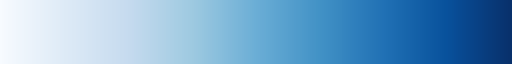

In [13]:
dag_get_cmap('Blues')

Saving L-1-csf-AULCSF in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom


SystemExit: 

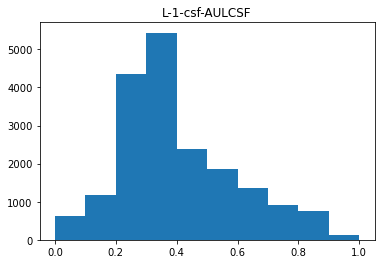

In [9]:
p_list = {
    # 'gauss' : [ 'size_1'] #'pol',    'ecc',  'size_1', 'rsq'],
    'csf' : ['AULCSF',]# 'width_r', 'sf0', 'maxC', 'sfmax', 'rsq']
    # 'css' : ['n_exp', 'rsq'],
    # 'dog' : ['size_1', 'rsq', 'size_ratio'],
    # 'norm' : ['']
}
sub_el = {
    'sub-01': -35,
    'sub-02': -20,
}
cmap_dict = {
    'width_r' : 'Reds_r',       
    'sf0' : 'Blues', 
    'sfmax' : 'Blues',
    'maxC' : 'Greens',
    'pol' : 'twilight',#'marco_pol',   
    'ecc' : 'ecc' ,    
    'rsq' : 'cool'  ,
    'size_1' : 'viridis',
    'AULCSF' : 'cool',     
}

vval_dict = {
    'pol': [-3.14, 3.14],
    'ecc': [0,5],
    'size_1': [0,8],
    'rsq': [0,1],
    'width_r': [0,3],
    'sf0' : [0,6],
    'maxC': [0, 200],
    'sfmax': [0, 20],
    'AULCSF' : [0,1],
    }
sc_folder = '/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/reports/'
for sub in ['sub-02']:#sub_list:
    fs = FSMaker(sub, fs_dir)
    for ses in ['1', '2']:
        for eye in ['L', 'R']:
            for m in p_list.keys():
                vx_mask = prf_multi[sub].return_vx_mask({
                    f'{eye}_{ses}_{m}-min-rsq':.1
                })
                for p in p_list[m]:
                    this_data = prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params[p]
                    surf_name = f'{eye}-{ses}-{m}-{p}'
                    plt.figure()
                    plt.title(surf_name)
                    plt.hist(this_data[vx_mask])
                    fs.add_surface(
                        data = this_data,
                        surf_name = surf_name,    
                        vmin = vval_dict[p][0], 
                        vmax = vval_dict[p][1], 
                        data_mask = vx_mask,
                        cmap = cmap_dict[p], 
                        cmap_nsteps=100
                    )
                    # fview_cmds = {
                    #     'do_scrn_shot' : True,
                    #     'azimuth' : 90,
                    #     'elevation' : sub_el[sub],
                    #     'scr_shot_file' : opj(sc_folder, sub)
                    # }
                    
                    fs.open_fs_surface(
                        surf_name=surf_name, 
                        mesh='inflated',
                        # **fview_cmds,
                        )     
                    sys.exit()
                    # bloop

# Do best possible polar map

In [86]:
sub = 'sub-02'
m = 'gauss'
x_list = []
y_list = []
rsq_list = []

for ses in ['1', '2']:
    for eye in ['L', 'R']:
        
        x_list.append(prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params['x'].to_numpy())
        y_list.append(prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params['y'].to_numpy())        
        this_rsq = prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].pd_params['rsq'].to_numpy()
        # vx_mask = prf_multi[sub].prf_obj[f'{eye}_{ses}_{m}'].return_vx_mask({'min-rsq':.1, 'max-ecc':5})
        # this_rsq[~vx_mask] = 0
        rsq_list.append(this_rsq)
        this_rsq = []

x_list = np.vstack(x_list)
y_list = np.vstack(y_list)
rsq_list = np.vstack(rsq_list)
wx_mean = dag_weighted_mean(rsq_list, x_list, axis=0)
wy_mean = dag_weighted_mean(rsq_list, y_list, axis=0)

wecc, wpol = dag_coord_convert(wx_mean, wy_mean, 'cart2pol')
p = 'pol'
fs = FSMaker(sub, fs_dir)
fs.add_surface(
    data = wpol,
    surf_name = 'wpol',    
    vmin = vval_dict[p][0], 
    vmax = vval_dict[p][1], 
    data_mask = ~np.isnan(wpol),
    cmap = cmap_dict[p], 
    cmap_nsteps=100
)

Saving wpol in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/custom


(array([ 6210.,  5503.,  4825.,  9651., 12453.,  8618.,  5973.,  2537.,
         3981.,  6560.]),
 array([-3.14147104e+00, -2.51317851e+00, -1.88488598e+00, -1.25659344e+00,
        -6.28300908e-01, -8.37448797e-06,  6.28284159e-01,  1.25657669e+00,
         1.88486923e+00,  2.51316176e+00,  3.14145429e+00]),
 <BarContainer object of 10 artists>)

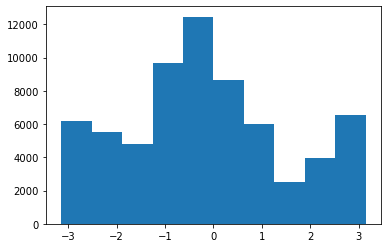

In [87]:
plt.hist(wpol[~np.isnan(wpol)])

In [88]:
fs.open_fs_surface(['wpol', 'L-1-gauss-pol', 'L-2-gauss-pol', 'R-1-gauss-pol', 'R-2-gauss-pol',])

L-1-gauss-pol not in dict
Checking custom surf dir
L-2-gauss-pol not in dict
Checking custom surf dir
R-1-gauss-pol not in dict
Checking custom surf dir
R-2-gauss-pol not in dict
Checking custom surf dir
L-1-gauss-pol not in dict
Checking custom surf dir
L-2-gauss-pol not in dict
Checking custom surf dir
R-1-gauss-pol not in dict
Checking custom surf dir
R-2-gauss-pol not in dict
Checking custom surf dir


In [73]:
np.isnan(wpol).sum()
np.where(np.sum(rsq_list,axis=0)<0)
rsq_list[:,68]
# rsq_list.min()
# wpol[68]

0.7853981633974483

In [34]:
i = 10
print(wx_list[i])
print(x_list[:,i])
print(rsq_list[:,i])
a = (rsq_list[0]<0.1) & (rsq_list[0]>0.01)
rsq_list[0][np.where(a)[0]]
# rsq_list[rsq_list<0.1] = 0
rsq_list.min()

3.148898962235913
[0.         0.         3.14889896 0.        ]
[0.         0.         0.25103109 0.        ]


-1.8501979789056984

In [ ]:
# tc_ses_1  = amb_load_real_tc_run(sub, ['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE'], ses='ses-1')
# tc_ses_2  = amb_load_real_tc_run(sub, ['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE'], ses='ses-2')

In [ ]:
# task_list = ['pRFLE', 'pRFRE', 'CSFLE', 'CSFRE']
# inten1 = {}
# inten2 = {}
# for task in task_list:
#     inten1[task] = np.mean(tc_ses_1[task], axis=(0,-1))
#     inten2[task] = np.mean(tc_ses_2[task], axis=(0,-1))

#     print(inten2[task].shape)


In [ ]:
# for task in task_list:
#     print(f'{task} - 1')
#     print(np.percentile(inten1[task], 99))
#     print(np.percentile(inten1[task], 1))

#     print('')
#     print(f'{task} - 2')
#     print(np.percentile(inten2[task], 99))
#     print(np.percentile(inten2[task], 1))    

In [ ]:
# fs = FSMaker(sub, fs_dir)

# # POLAR 
# for task in task_list:
#     fs.add_surface(
#         data = inten1[task],
#         surf_name = f'int1-{task}',    
#         cmap = 'magma', 
#         vmin=0, vmax=100000,
#     )    
#     fs.add_surface(
#         data = inten2[task],
#         surf_name = f'int2-{task}',    
#         cmap = 'magma', 
#         vmin=0, vmax=100000,
#     )        

# fs.open_fs_surface(
#     fs.surf_list, 
#     mesh='inflated', 
#     # roi_list=['v1custom', 'v2custom', 'v3custom', 'LOcustom']
#     )    

In [ ]:
# # for task in task_list:
# #     plt.figure()
# #     plt.hist(inten1[task], color='b', alpha=0.5)
# #     plt.hist(inten2[task], color='g', alpha=0.5)

# for task in ['pRF', 'CSF']:
#     plt.figure()
#     # plt.hist(inten1[f'{task}LE'], color='#9ecae1', alpha=0.5)
#     plt.hist(inten2[f'{task}LE'], color='#3182bd', alpha=0.5)
#     # plt.hist(inten1[f'{task}RE'], color='#a1d99b', alpha=0.5)
#     plt.hist(inten2[f'{task}RE'], color='#31a354', alpha=0.5)

#     # plt.hist(inten2[task], color='g', alpha=0.5)


In [ ]:
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFLE-hrf_deriv', alpha=0.5)
# # # all_prf_obj.rapid_hist(ax=plt.gca(), px='pRFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFRE-hrf_deriv', alpha=0.5)
# # all_prf_obj.rapid_hist(ax=plt.gca(), px='CSFLE-hrf_deriv', alpha=0.5)

eye = 'R'
prf_multi.rapid_p_corr(
    f'{eye}_1_csf-rsq',
    f'{eye}_2_csf-rsq', 
    th={f'{eye}_1_csf-min-rsq':.1, f'{eye}_2_csf-min-rsq':.1}, do_id_line=True,
    do_line=True, line_col='r', dot_col='k', dot_alpha=.5)

In [ ]:
# prf_dE = Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['pRFRE']['gauss'], id1='prfLE', id2='prfRE')
# csf_dE = Prf1T1Mx2(prf_obj['CSFLE']['csf'], prf_obj['CSFRE']['csf'], id1='csfLE', id2='csfRE')
# le_dT =  Prf1T1Mx2(prf_obj['pRFLE']['gauss'], prf_obj['CSFLE']['csf'], id1='prfLE', id2='csfLE')
# re_dT =  Prf1T1Mx2(prf_obj['pRFRE']['gauss'], prf_obj['CSFRE']['csf'], id1='prfRE', id2='csfRE')

In [ ]:
fs = FSMaker(sub, fs_dir)
model = 'gauss'
# POLAR 
for task in ['pRFLE', 'pRFRE']:
    # fs.add_surface(
    #     data = prf_obj[task][model].pd_params['pol'],
    #     surf_name = f'{sub}-{task}-{model}-pol',    
    #     vmin = -np.pi, vmax=np.pi , # min and max values of polar anlge 
    #     data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
    #     cmap = 'hsv_hsv', # using hsv for polar angle, can use something else...
    # )
    # POL CLOCK
    clock_val = dag_pol_to_clock(prf_obj[task][model].pd_params['pol'])
    fs.add_surface(
        data = clock_val,
        surf_name = f'{sub}-{task}-{model}-pol-clock',    
        vmin = 0, vmax=12, # min and max values of polar anlge 
        data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
        cmap = 'hsv', # using hsv for polar angle, can use something else...
        cmap_nsteps=100
    )    
# model = 'csf'
# for task in ['CSFLE', 'CSFRE']:
#     fs.add_surface(
#         data = clock_val,
#         surf_name = f'{sub}-{task}-{model}-pol-clock',    
#         vmin = 0, vmax=12, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'twilight', # using hsv for polar angle, can use something else...
#         cmap_nsteps=20
#     )        


# # d_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['d_val'],
#         surf_name = f'{sub}-{task}-{model}-d_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'jet', # using hsv for polar angle, can use something else...
#     )


# # b_val
# model = 'norm'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['b_val'],
#         surf_name = f'{sub}-{task}-{model}-b_val',    
#         vmin = 0, vmax=100, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'viridis', # using hsv for polar angle, can use something else...
#     )


# size_1
# model = 'gauss'
# for task in task_list:
#     fs.add_surface(
#         data = prf_obj[task][model].pd_params['size_1'],
#         surf_name = f'{sub}-{task}-{model}-size_1',    
#         vmin = 0, vmax=10, # min and max values of polar anlge 
#         data_mask=prf_obj[task][model].return_vx_mask({'min-rsq':.1}),
#         cmap = 'ecc', # using hsv for polar angle, can use something else...
#     )
